# Procedures and Functions Tutorial

MLDB is the Machine Learning Database, and all machine learning operations are done via Procedures and Functions. Training a model happens via Procedures, and applying a model happens via Functions.

The notebook cells below use `pymldb`'s `Connection` class to make [REST API](/doc/#builtin/WorkingWithRest.md.html) calls. You can check out the [Using `pymldb` Tutorial](/doc/nblink.html#_tutorials/Using pymldb Tutorial) for more details.

In [10]:
from pymldb import Connection
mldb = Connection("http://localhost")

## Loading a Dataset 

The classic [Iris Flower Dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set) isn't very big but it's well-known and easy to reason about so it's a good example dataset to use for machine learning examples.

We can load it as a [`text.csv.tabular` Dataset](/doc/#builtin/datasets/TabularCsvDataset.md.html) directly from a remote URL:


In [2]:
mldb.put('/v1/datasets/iris', {
    "type": "text.csv.tabular",
    "params": {
        "dataFileUrl": "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
        "headers": [ "sepal length", "sepal width", "petal length", "petal width", "class" ]
    }
})

<Response [201]>

## A quick look at the data

We can use the [Query API](/doc/#builtin/sql/QueryAPI.md.html) to get the data into a Pandas DataFrame to take a quick look at it.

In [3]:
df = mldb.query("select * from iris")
df.head()

,sepal length,sepal width,petal length,petal width,class
_rowName,,,,,
97,5.7,2.9,4.2,1.3,Iris-versicolor
11,5.4,3.7,1.5,0.2,Iris-setosa
112,6.4,2.7,5.3,1.9,Iris-virginica
134,6.3,2.8,5.1,1.5,Iris-virginica
142,6.9,3.1,5.1,2.3,Iris-virginica


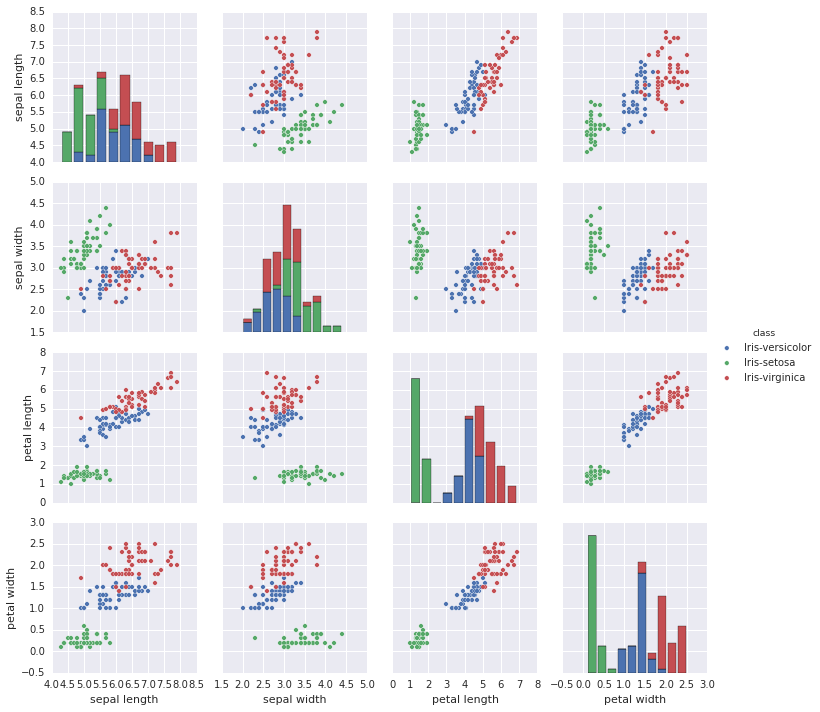

In [4]:
%matplotlib inline
import seaborn as sns

sns.pairplot(df, hue="class", size=2.5)

## Unsupervised Machine Learning with a `kmeans.train` Procedure

We will create and run a [Procedure](/doc/#builtin/procedures/Procedures.md.html) of type [`kmeans.train`](/doc/#builtin/procedures/KmeansProcedure.md.html). This will train an unsupervised K-Means model and use it to assign each row in the input to a cluster, in the output dataset.

In [5]:
mldb.put('/v1/procedures/iris_train_kmeans', {
    'type' : 'kmeans.train',
    'params' : {
        'trainingData' : 'select * EXCLUDING(class) from iris',
        'outputDataset' : 'iris_clusters',
        'numClusters' : 3,
        'metric': 'euclidean',
        "runOnCreation": True
    }
})

<Response [201]>

Now we can look at the output dataset and compare the clusters the model learned with the three types of flower in the dataset.

In [6]:
mldb.query("""
    select pivot(class, num) as *
    from (
        select cluster, class, count(*) as num
        from merge(iris_clusters, iris)
        group by cluster, class
    )
    group by cluster
""")

,Iris-setosa,Iris-versicolor,Iris-virginica
_rowName,,,
[0],50,NaN,NaN
[1],NaN,2,36
[2],NaN,48,14


As you can see, the K-means algorithm does a terrible job of clustering this data (as is mentioned in the Wikipedia article!).

## Supervised Machine Learning with a `classifier.train` Procedure

We will now create and run a [Procedure](/doc/#builtin/procedures/Procedures.md.html) of type [`classifier.train`](/doc/#builtin/procedures/Classifier.md.html). The configuration below will use 20% of the data to train a decision tree to classify rows into the three classes of Iris. The output of this procedure is a [Function](/doc/#builtin/functions/Functions.md.html), which we will be able to call from REST or SQL.

In [7]:
mldb.put('/v1/procedures/iris_train_classifier', {
    'type' : 'classifier.train',
    'params' : {
        'trainingData' : """
            select 
                {* EXCLUDING(class)} as features, 
                class as label 
            from iris 
            where rowHash() % 5 = 0
        """,
        "algorithm": "dt",
        "modelFileUrl": "file://models/iris.cls",
        "mode": "categorical",
        "functionName": "iris_classify",
        "runOnCreation": True
    }
})

<Response [201]>

We can call the Function REST API endpoint to classify a never-before-seen set of measurements like this:

In [8]:
mldb.get('/v1/functions/iris_classify/application', input={
    "features":{
        "petal length": 1,
        "petal width": 2,
        "sepal length": 3,
        "sepal width": 4
    }
})

<Response [200]>

We can now also apply this classifier to the subset of the data we didn't use for training, using SQL:

In [9]:
mldb.query("""
        select sum(
            iris_classify({
                features: {* EXCLUDING(class)}
            })[scores]
        ) as *
        from iris
        where rowHash() % 5 != 0
        group by class
""")

,"""Iris-setosa""","""Iris-versicolor""","""Iris-virginica"""
_rowName,,,
"[""Iris-setosa""]",40,0,0
"[""Iris-versicolor""]",0,37,2
"[""Iris-virginica""]",0,6,38


As you can see, the decision tree does a much better job of classifying the data than the K-means model, using 20% of the examples as training data.

## Where to next?

Check out the other [Tutorials and Demos](/doc/#builtin/Demos.md.html).